Здесь надо привести нормализованные данные к входам дерева и обучиться на этих данных.

Для этого может потребоваться настройка параметров для фильтров, выбор фильтров, настройка агрегации и т.п, поэтому отдельно не выношу.

In [1]:
import os

input_dir = "data/pvs-converted"
output_dir = "data/pvs-cart"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [2]:
def flat_map(input):
  lst = []
  for elem in input:
    lst.extend(elem)
  return lst


input_fname_indexes = flat_map([[f"{i}-right", f"{i}-left"] for i in range(1, 10)])

In [3]:
import pandas as pd

input_dfs = []

def get_raw_inputs(input_fname):
  df = pd.read_csv(input_fname)
  acDf = df[['timestamp', 'acc_x_dashboard', 'acc_y_dashboard', 'acc_z_dashboard']]
  gyDf = df[['timestamp', 'gyro_x_dashboard', 'gyro_y_dashboard', 'gyro_z_dashboard']]
  gpsDf = df[['timestamp_gps', 'latitude', 'longitude']]
  predDf = df[['timestamp', 'good_road', 'regular_road', 'bad_road']]

  out = (acDf, gyDf, gpsDf, predDf)
  print(input_fname, *map(lambda x: x.shape, out))
  return out


# input_normalized_file_paths = list(map(lambda x: os.path.join(input_dir, f"{x}-normalized.csv"), input_fname_indexes))

for input_fname_index in input_fname_indexes:
  input_normalized_fpath = os.path.join(input_dir, f"{input_fname_index}-normalized.csv")
  input_dfs.append((*get_raw_inputs(input_normalized_fpath), input_fname_index))
  

/tmp/ipykernel_1345809/3579307478.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


data/pvs-converted/1-right-normalized.csv (144036, 4) (144036, 4) (144036, 3) (144036, 4)
data/pvs-converted/1-left-normalized.csv (144036, 4) (144036, 4) (144036, 3) (144036, 4)
data/pvs-converted/2-right-normalized.csv (124684, 4) (124684, 4) (124684, 3) (124684, 4)
data/pvs-converted/2-left-normalized.csv (124684, 4) (124684, 4) (124684, 3) (124684, 4)
data/pvs-converted/3-right-normalized.csv (105816, 4) (105816, 4) (105816, 3) (105816, 4)
data/pvs-converted/3-left-normalized.csv (105816, 4) (105816, 4) (105816, 3) (105816, 4)
data/pvs-converted/4-right-normalized.csv (132492, 4) (132492, 4) (132492, 3) (132492, 4)
data/pvs-converted/4-left-normalized.csv (132492, 4) (132492, 4) (132492, 3) (132492, 4)
data/pvs-converted/5-right-normalized.csv (133877, 4) (133877, 4) (133877, 3) (133877, 4)
data/pvs-converted/5-left-normalized.csv (133877, 4) (133877, 4) (133877, 3) (133877, 4)
data/pvs-converted/6-right-normalized.csv (96279, 4) (96279, 4) (96279, 3) (96279, 4)
data/pvs-converted/

Copy library code to test with different params and stop caching imports

In [4]:
import pandas
import numpy
from scipy.signal import lfilter, iirfilter

tick = 25000
window = 128
slide = 0.5


In [5]:
def get_df_time_range(df: pandas.DataFrame):
    l = len(df.index)
    return (df.iloc[0].time, df.iloc[l - 1].time, l)


def get_diff_time(start: int, end: int):
    return end - start


# get interpolated values:
# - (1_000_000/tick) HZ accelerometer, gyroscope
# - ((tick * window * slide)/1_000_000) seconds period GPS
def interpolate(
    acDf: pandas.DataFrame, gyDf: pandas.DataFrame, gpsDf: pandas.DataFrame
):
    acTse = get_df_time_range(acDf)
    gyTse = get_df_time_range(gyDf)
    gpsTse = get_df_time_range(gpsDf)

    minTime = int(max(acTse[0], gyTse[0], gpsTse[0]))
    maxTime = int(min(acTse[1], gyTse[1], gpsTse[1]))

    sensorInterpTimes = numpy.arange(minTime, maxTime, tick)
    # print(sensorInterpTimes, len(sensorInterpTimes), sep="\n")

    gpsInterpTimes = numpy.arange(
        minTime + int(tick * window * slide / 2),
        maxTime + int(tick * window * slide / 2),
        int(tick * window * slide),
    )
    # print(gpsInterpTimes, len(gpsInterpTimes), sep="\n")

    acTimes = acDf.time.to_numpy()
    gyTimes = gyDf.time.to_numpy()
    gpsTimes = gpsDf.time.to_numpy()

    acX = acDf.x.to_numpy()
    acY = acDf.y.to_numpy()
    acZ = acDf.z.to_numpy()

    gyX = gyDf.x.to_numpy()
    gyY = gyDf.y.to_numpy()
    gyZ = gyDf.z.to_numpy()

    acXi = numpy.interp(sensorInterpTimes, acTimes, acX)
    acYi = numpy.interp(sensorInterpTimes, acTimes, acY)
    acZi = numpy.interp(sensorInterpTimes, acTimes, acZ)
    gyXi = numpy.interp(sensorInterpTimes, gyTimes, gyX)
    gyYi = numpy.interp(sensorInterpTimes, gyTimes, gyY)
    gyZi = numpy.interp(sensorInterpTimes, gyTimes, gyZ)

    gpsLat = gpsDf.latitude.to_numpy()
    gpsLon = gpsDf.longitude.to_numpy()

    gpsLoni = numpy.interp(gpsInterpTimes, gpsTimes, gpsLon)
    gpsLati = numpy.interp(gpsInterpTimes, gpsTimes, gpsLat)

    acDf1 = pandas.DataFrame(
        {"time": sensorInterpTimes, "x": acXi, "y": acYi, "z": acZi}
    )
    gyDf1 = pandas.DataFrame(
        {"time": sensorInterpTimes, "x": gyXi, "y": gyYi, "z": gyZi}
    )
    gpsDf1 = pandas.DataFrame(
        {"time": gpsInterpTimes, "latitude": gpsLati, "longitude": gpsLoni}
    )

    return (acDf1, gyDf1, gpsDf1)


In [6]:
# interpolate sensors data, predictions

input_dfs_harmonised = []

def rename_df_cols(acDf, gyDf, gpsDf, predDf):
  acDfr = acDf.rename(
    columns={"timestamp": "time", "acc_x_dashboard": "x", "acc_y_dashboard": "y", "acc_z_dashboard": "z"}) 
  gyDfr = gyDf.rename(
    columns={"timestamp": "time", "gyro_x_dashboard": "x", "gyro_y_dashboard": "y", "gyro_z_dashboard": "z"})
  gpsDfr = gpsDf.rename(
    columns={"timestamp_gps": "time"})
  predDfr = predDf.rename(
    columns={"timestamp": "time"}
  )
  return (acDfr, gyDfr, gpsDfr, predDfr)


# get prediction based on window avg.
# good -> 1, regular -> 0.5, bad -> 0
# find min on window
def harmonise_prediction(time_markers: numpy.array, predDf):
  data = []
  for marker in time_markers:
    start = marker - int(tick * window * slide / 2)
    end = marker + int(tick * window * slide / 2)
    # NOTE: not optimized
    predDfr = predDf[(predDf.time >= start) & (predDf.time <= end)]
    res = (predDfr.good_road * 1 + predDfr.regular_road * 0.5 + predDfr.bad_road * 0).min()
    data.append((marker, res))
  return pd.DataFrame(data, columns=["time", "prediction"])


for (acDf, gyDf, gpsDf, predDf, input_fpath) in input_dfs:
  acDfr, gyDfr, gpsDfr, predDfr = rename_df_cols(acDf, gyDf, gpsDf, predDf)
  acDfi, gyDfi, gpsDfi = interpolate(acDfr, gyDfr, gpsDfr)

  predDfi = harmonise_prediction(gpsDfi["time"].to_numpy(), predDfr)
  entry = (acDfi, gyDfi, gpsDfi, predDfi, input_fpath)
  print(entry[4])
  input_dfs_harmonised.append(entry)



1-right
1-left
2-right
2-left
3-right
3-left
4-right
4-left
5-right
5-left
6-right
6-left
7-right
7-left
8-right
8-left
9-right
9-left


In [7]:
# split into raw algorithm inputs
point_raw_entries = []

def get_point_raw_inputs_wpred(acDf, gyDf, gpsDf, predDf):
  entries = []
  total = len(acDf)
  for i in range(0, len(predDf)):
    start_i = i * int(window * slide)
    end_i = start_i + window
    if end_i >= total:
      break
    
    acE = acDf[start_i: end_i]
    gyE = gyDf[start_i: end_i]
    gpsE = gpsDf.iloc[[i]].to_dict('records')[0] # not using Series because of type casts
    predE = predDf.iloc[i]
    entries.append((acE, gyE, gpsE, predE,))
  return entries

def get_point_raw_inputs(acDf, gyDf, gpsDf):
  entries = []
  total = len(acDf)
  for i in range(0, len(predDf)):
    start_i = i * int(window * slide)
    end_i = start_i + window
    if end_i >= total:
      break
    
    acE = acDf[start_i: end_i]
    gyE = gyDf[start_i: end_i]
    gpsE = gpsDf.iloc[[i]].to_dict('records')[0] # not using Series because of type casts
    entries.append((acE, gyE, gpsE, ))
  return entries


for (acDf, gyDf, gpsDf, predDf, input_fpath) in input_dfs_harmonised:
  point_raw_entries.extend(get_point_raw_inputs_wpred(acDf, gyDf, gpsDf, predDf))
  print(input_fpath)

print(len(point_raw_entries))


1-right
1-left
2-right
2-left
3-right
3-left
4-right
4-left
5-right
5-left
6-right
6-left
7-right
7-left
8-right
8-left
9-right
9-left
13322


In [8]:
import json

raw_dir = os.path.join(output_dir, "raw")
if not os.path.exists(raw_dir):
    os.makedirs(raw_dir)

# write each entry to separate file (can be changed)
for i, (acDf, gyDf, gpsD, predS) in enumerate(point_raw_entries):
  out = {}
  out["accelerometer"] = acDf[["x", "y", "z"]].to_dict(orient='records')
  out["gyroscope"] = gyDf[["x", "y", "z"]].to_dict(orient='records')
  out["gps"] = {"latitude": gpsD["latitude"], "longitude": gpsD["longitude"]}
  out["prediction"] = predS["prediction"]
  with open(os.path.join(raw_dir, f"{i}.json"), "w") as file:
    json.dump(out, file)


In [342]:
import numpy as np

# signal processing for input batch
fs = 1000000 / tick
filter_N = 4
filter_freq = 10

# noice reduction can be performed optimized on all input (but not only on window), no difference in implementation
def reduce_noice(acDf: pandas.DataFrame, gyDf: pandas.DataFrame):
    b, a = iirfilter(filter_N, Wn=filter_freq, fs=fs, btype="low", ftype="butter")

    acX = lfilter(b, a, acDf.x)
    acY = lfilter(b, a, acDf.y)
    acZ = lfilter(b, a, acDf.z)

    gyX = lfilter(b, a, gyDf.x)
    gyY = lfilter(b, a, gyDf.y)
    gyZ = lfilter(b, a, gyDf.z)

    acDf1 = acDf.copy()
    gyDf1 = gyDf.copy()
    
    acDf1["x"] = acX
    acDf1["y"] = acY
    acDf1["z"] = acZ

    gyDf1["x"] = gyX
    gyDf1["y"] = gyY
    gyDf1["z"] = gyZ

    return (acDf1, gyDf1)
    # acil = (acXil**2 + acYil**2 + acZil**2) ** 0.5
    # gyil = (gyXil**2 + gyYil**2 + gyZil**2) ** 0.5


# compute magnitude on all axis, apply fast fft transformation, 
# get 32 elements of each (accelerometer, gyroscope), max acceleromet, max gyroscope
def extract_features(acDf: pandas.DataFrame, gyDf: pandas.DataFrame):
    acM = (acDf["x"] ** 2 + acDf["y"] ** 2 + acDf["z"] ** 2) ** 0.5
    gyM = (gyDf["x"] ** 2 + gyDf["y"] ** 2 + gyDf["z"] ** 2) ** 0.5
    maxAc = max(acM)
    maxGy = max(gyM)

    acFft = np.fft.fft(acM)
    gyFft = np.fft.fft(gyM)
    # frequencies = np.fft.fftfreq(window, 1/fs)
    maxFB = int(window * filter_freq / fs)
    
    arrays = (np.abs(acFft[:maxFB]), np.abs(gyFft[:maxFB]), [maxAc, maxGy])
    features = np.concatenate(arrays)
    return features



In [343]:
# reduce noice, extract features (with fft), write
import matplotlib.pyplot as plt

entry_fpaths = [os.path.join(raw_dir, x) for x in os.listdir(raw_dir)]
out_file = os.path.join(output_dir, "features-predictions.csv")

def read_entry(entry_fpath):
  with open(entry_fpath) as file:
      data = json.load(file)
      acDf = pd.DataFrame.from_records(data["accelerometer"])
      gyDf = pd.DataFrame.from_records(data["gyroscope"])
      gpsDf = pd.Series(data["gps"])
      prediction = data["prediction"]
      return (acDf, gyDf, gpsDf, prediction)

def display_sensors(acDf, gyDf):
  plt.figure().set_figwidth(20)
  plt.plot(range(0, len(acDf)), acDf["x"].to_numpy(), '-', label="AC")
  plt.plot(range(0, len(gyDf)), gyDf["x"].to_numpy(), '-', label="GY")

def display_features(features):
  plt.figure().set_figwidth(20)
  plt.plot(range(0, len(features)), features)

features_predictions = []

for entry_fpath in entry_fpaths:
    acDf, gyDf, gpsDf, prediction = read_entry(entry_fpath)
    acDfn, gyDfn = reduce_noice(acDf, gyDf)
    features = extract_features(acDf, gyDf)
    features_predictions.append([*features, prediction])
    # if prediction == 0.5:
    #   display_sensors(acDfn, gyDfn)
    #   display_features(features)
    #   print(features)
    #   break
    
features_cnt = len(features_predictions[0])
features_prediction_df_columns = [str(i) for i in range(0, features_cnt - 1)] + ["prediction"]
features_prediction_df = pd.DataFrame(features_predictions, columns=features_prediction_df_columns)
features_prediction_df.to_csv(out_file, index=False)

In [344]:
# select only featues with least correlation
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

features_prediction_df = pd.read_csv(out_file)

corr_matrix = features_prediction_df.corr()
corr_with_prediction = corr_matrix['prediction']


correlations = corr_with_prediction.abs().sort_values(ascending=False)
print(correlations)

# select only top k features
k = 24
selected_feature_indexes = correlations[1:k+1].index

out_features_predictions_selected_fpath = os.path.join(output_dir, f"features-predictions-selected-{k}.csv")
features_prediction_df_selected = features_prediction_df[[*selected_feature_indexes, 'prediction']]
features_prediction_df_selected.to_csv(out_features_predictions_selected_fpath, index=False)

with open(os.path.join("model", f"selected-features-{k}.json"), "w") as file:
  json.dump(list(map(int, selected_feature_indexes)), file)


prediction    1.000000
0             0.695214
64            0.667900
65            0.626631
32            0.566991
                ...   
3             0.438889
34            0.432683
2             0.413789
33            0.336610
1             0.334522
Name: prediction, Length: 67, dtype: float64


In [345]:
from sklearn import tree
from sklearn.tree import export_graphviz, export_text
from sklearn.model_selection import train_test_split

data = pd.read_csv(out_features_predictions_selected_fpath)
clf = tree.DecisionTreeRegressor(criterion='squared_error', max_depth=5, min_samples_split=2, min_samples_leaf=1)

data_shuffled = features_prediction_df_selected.sample(frac=1)

X = data_shuffled.drop(['prediction'], axis=1)
y = data_shuffled['prediction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = clf.fit(X_train.values, y_train)

In [346]:
tree_text_path = os.path.join(output_dir, "tree-cart.txt")
tree_graphviz_path = os.path.join(output_dir, "tree-cart.dot")

with open(tree_text_path, "w") as file:
  file.write(export_text(clf))

with open(tree_graphviz_path, "w") as file:
  file.write(export_graphviz(clf))

In [347]:
import pickle

model_dir = "model"

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

with open(os.path.join(model_dir, f"tree-cart-features-{k}.pickle"), "wb") as file:
    pickle.dump(clf, file)

In [348]:
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

def regression_results(y_pred, y_true):
    # Regression metrics
    r2=metrics.r2_score(y_true, y_pred)
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)

    print('R2: ', round(r2,4)) 
    print('Explained variance (biased): ', round(explained_variance,4)) # if mean(error)=0, then R2 = explained variance score
    print('MSE: ', round(mse,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    print('MSLE: ', round(mean_squared_log_error,4)) # mean squared logarithmic error



def visualize_sorted_results(y_pred: numpy.array, y_true: numpy.array):
    y_true_ids = y_true.argsort()
    y_true_sorted = y_true[y_true_ids[::-1]]
    y_pred_sorted = y_pred[y_true_ids[::-1]]
    l = len(y_true_sorted)

    plt.figure().set_figwidth(20)
    plt.scatter(range(0, l), y_true_sorted, label="True", s=5)
    plt.scatter(range(0, l), y_pred_sorted, label="Predicted", s=1)

def distribution_results(y_pred: numpy.array, y_true: numpy.array):
    total = 10
    step = 1 / total
    for i in range(0, total + 1):
        lower_bound = i * step
        upper_bound = (i + 1) * step
        y_true_mask = (y_true >= lower_bound) & (y_true < upper_bound)
        y_pred_dist = [0] * total
        for j in range(0, len(y_true)):
            if y_true_mask[j] == False:
                continue
            bucket = int((y_pred[j] - 0.001) / step)
            y_pred_dist[bucket] += 1

        cnt = y_true_mask.sum()
        if cnt != 0:
            rounded_distribution = [round(v/cnt, 3) for v in y_pred_dist]
            print(f"[{round(lower_bound,2)}...{round(upper_bound, 2)}]={cnt}:\t{'/'.join(map(str, rounded_distribution))}")


R2:  0.6408
Explained variance (biased):  0.6408
MSE:  0.0525
MAE:  0.1667
RMSE:  0.2292
MSLE:  0.0298
[0.0...0.1]=860:	0.0/0.0/0.184/0.59/0.181/0.0/0.007/0.012/0.007/0.02
[0.5...0.6]=1512:	0.0/0.001/0.077/0.617/0.243/0.0/0.005/0.008/0.009/0.039
[1.0...1.1]=1630:	0.001/0.001/0.004/0.011/0.035/0.0/0.001/0.023/0.015/0.91


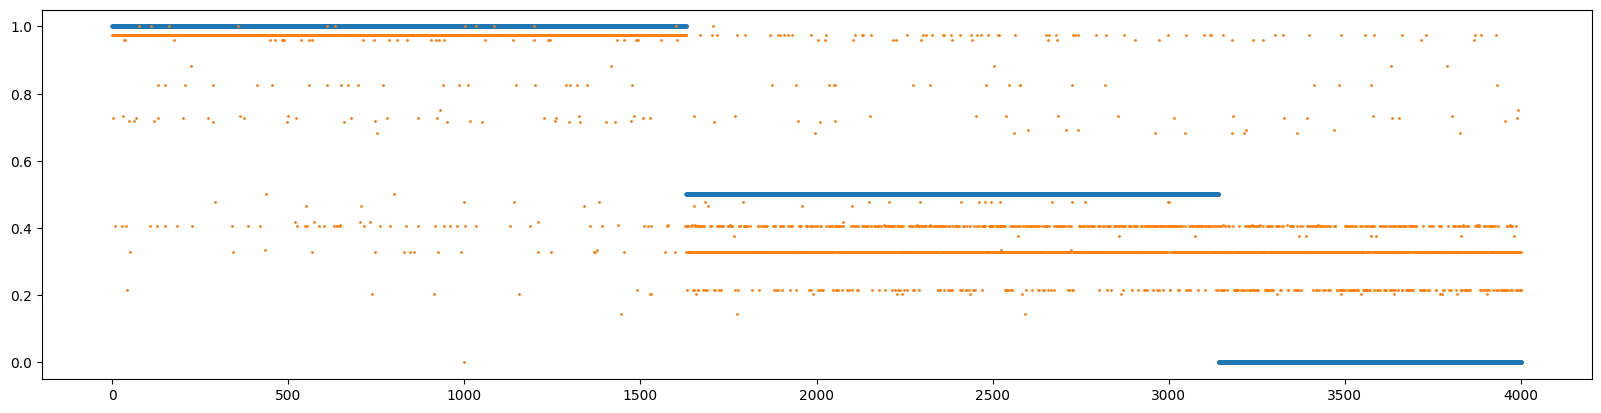

In [349]:
with open(os.path.join(model_dir, f"tree-cart-features-{k}.pickle"), "rb") as file:
  clf = pickle.load(file)
  y_predicted = clf.predict(X_test.values)

  regression_results(y_predicted, y_test.to_numpy())
  visualize_sorted_results(y_predicted, y_test.to_numpy())
  distribution_results(y_predicted, y_test.to_numpy())